In [ ]:
%pip install torch torch-geometric meshio numpy matplotlib

In [ ]:
!pip install tqdm trimesh

In [ ]:
!unzip data.zip

In [3]:
import meshio, numpy as np, torch
import matplotlib.pyplot as plt
import torch_geometric

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

In [4]:
from collections import defaultdict
import trimesh


def build_edge_index(triangles, num_nodes):
    # Undirected edges from triangle list
    edges = set()
    for i, j, k in triangles:
        edges |= {(i, j), (j, k), (k, i)}
    edge_idx = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    return edge_idx

def angle_between_vectors_numpy(v1, v2, normalize=True, epsilon=1e-8):
    """Computes the angle in radians between pairs of vectors in NumPy arrays."""
    if normalize:
        v1_norm = np.linalg.norm(v1, axis=1, keepdims=True)
        v2_norm = np.linalg.norm(v2, axis=1, keepdims=True)
        v1 = v1 / (v1_norm + epsilon)
        v2 = v2 / (v2_norm + epsilon)
    dot_product = np.sum(v1 * v2, axis=1)
    dot_product = np.clip(dot_product, -1.0 + epsilon, 1.0 - epsilon)
    return np.arccos(dot_product)

def load_graph_with_edge_features(xdmf_path):
    """
    Loads a graph from an XDMF file and computes node and edge features.
    Handles non-triangular meshes by triangulating them.
    Node features: [coords (3), degree (1)].
    Edge features: [dihedral_angle (1), min_inner_angle (1), max_inner_angle (1),
                    min_edge_ratio (1), max_edge_ratio (1)].
    """
    # Load mesh
    mesh = meshio.read(xdmf_path)
    pts_np = mesh.points.astype(np.float32)

    # Check for triangular or non-triangular mesh
    if "triangle" in mesh.cells_dict:
        triangles_np = mesh.cells_dict["triangle"].astype(np.int64)
    else:
        # Handle non-triangular meshes (e.g., quads)
        faces = mesh.cells_dict.get("quad", None)
        if faces is None:
            raise ValueError(f"No triangle or quad cells found in {xdmf_path}. Available cells: {mesh.cells_dict.keys()}")
        # Triangulate using trimesh
        tri_mesh = trimesh.Trimesh(vertices=pts_np, faces=faces)
        tri_mesh.process(validate=True)
        tri_mesh = tri_mesh.subdivide()  # Subdivide ensures triangulation
        pts_np = tri_mesh.vertices.astype(np.float32)
        triangles_np = tri_mesh.faces.astype(np.int64)

    num_nodes = pts_np.shape[0]

    # 1. Compute unit normals for all faces
    v0 = pts_np[triangles_np[:, 0]]
    v1 = pts_np[triangles_np[:, 1]]
    v2 = pts_np[triangles_np[:, 2]]
    vec1 = v1 - v0
    vec2 = v2 - v0
    normals_np = np.cross(vec1, vec2)
    norms = np.linalg.norm(normals_np, axis=1, keepdims=True)
    unit_normals_np = normals_np / (norms + 1e-8)

    # 2. Build edge_index and edge_to_faces map
    edge_set = set()
    edge_to_faces = defaultdict(list)
    for i, face_v_indices in enumerate(triangles_np):
        e1 = tuple(sorted((face_v_indices[0], face_v_indices[1])))
        e2 = tuple(sorted((face_v_indices[1], face_v_indices[2])))
        e3 = tuple(sorted((face_v_indices[2], face_v_indices[0])))
        for edge in [e1, e2, e3]:
            edge_set.add(edge)
            edge_to_faces[edge].append(i)
    unique_edges_list = list(edge_set)
    num_edges = len(unique_edges_list)
    unique_edges_np = np.array(unique_edges_list)

    # Create PyTorch edge_index (undirected)
    edge_index = torch.tensor([[v1, v2] for v1, v2 in unique_edges_list] +
                              [[v2, v1] for v1, v2 in unique_edges_list],
                              dtype=torch.long).t().contiguous()

    # 3. Generate edge-face pairs
    edge_face_pairs = [(e_idx, f_idx) for e_idx, edge in enumerate(unique_edges_list)
                       for f_idx in edge_to_faces[edge]]
    edge_indices = np.array([pair[0] for pair in edge_face_pairs])
    face_indices = np.array([pair[1] for pair in edge_face_pairs])
    num_pairs = len(edge_face_pairs)

    # 4. Extract vertices for all pairs
    edge_vertices = unique_edges_np[edge_indices]
    face_vertices = triangles_np[face_indices]

    # 5. Find opposite vertices
    diff0 = face_vertices != edge_vertices[:, 0][:, None]
    diff1 = face_vertices != edge_vertices[:, 1][:, None]
    opposite_mask = diff0 & diff1
    opposite_vertex_indices = face_vertices[np.arange(num_pairs), np.argmax(opposite_mask, axis=1)]

    # 6. Get coordinates
    p_edge_v1_np = pts_np[edge_vertices[:, 0]]
    p_edge_v2_np = pts_np[edge_vertices[:, 1]]
    p_opposite_v_np = pts_np[opposite_vertex_indices]

    # 7. Compute inner angles
    vec_opp_to_e1 = p_edge_v1_np - p_opposite_v_np
    vec_opp_to_e2 = p_edge_v2_np - p_opposite_v_np
    inner_angles_rad = angle_between_vectors_numpy(vec_opp_to_e1, vec_opp_to_e2)

    # 8. Compute edge length ratios
    edge_len = np.linalg.norm(p_edge_v2_np - p_edge_v1_np, axis=1)
    vec_edge = p_edge_v2_np - p_edge_v1_np
    vec_e1_to_opp = p_opposite_v_np - p_edge_v1_np
    area = 0.5 * np.linalg.norm(np.cross(vec_edge, vec_e1_to_opp), axis=1)
    height = np.where(area < 1e-9, 1e-7, (2 * area) / (edge_len + 1e-8))
    edge_length_ratio_val = np.where(edge_len < 1e-7, 1.0,
                                     np.where(height < 1e-7, edge_len / 1e-7, edge_len / height))

    # 9. Aggregate features per edge
    sort_idx = np.argsort(edge_indices)
    sorted_edge_indices = edge_indices[sort_idx]
    sorted_inner_angles = inner_angles_rad[sort_idx]
    sorted_edge_ratios = edge_length_ratio_val[sort_idx]
    _, counts = np.unique(sorted_edge_indices, return_counts=True)
    split_points = np.cumsum(counts[:-1])
    inner_groups = np.split(sorted_inner_angles, split_points)
    ratio_groups = np.split(sorted_edge_ratios, split_points)
    min_inner_angles = np.array([np.min(g) for g in inner_groups])
    max_inner_angles = np.array([np.max(g) for g in inner_groups])
    min_edge_ratios = np.array([np.min(g) for g in ratio_groups])
    max_edge_ratios = np.array([np.max(g) for g in ratio_groups])

    # 10. Compute dihedral angles for internal edges
    internal_edge_indices = [i for i, edge in enumerate(unique_edges_list)
                             if len(edge_to_faces[edge]) == 2]
    internal_edge_faces = np.array([edge_to_faces[unique_edges_list[i]]
                                    for i in internal_edge_indices])
    n1 = unit_normals_np[internal_edge_faces[:, 0]]
    n2 = unit_normals_np[internal_edge_faces[:, 1]]
    dihedral_angles = angle_between_vectors_numpy(n1, n2)
    all_dihedral_angles = np.zeros(num_edges)
    all_dihedral_angles[internal_edge_indices] = dihedral_angles

    # 11. Assemble edge features
    edge_features_np = np.column_stack([
        all_dihedral_angles,
        min_inner_angles,
        max_inner_angles,
        min_edge_ratios,
        max_edge_ratios
    ])
    edge_features_np = np.nan_to_num(edge_features_np, nan=0.0, posinf=1.0, neginf=0.0)
    edge_features_tensor = torch.from_numpy(edge_features_np).float()

    # Duplicate edge features for undirected edges ([v1, v2] and [v2, v1])
    edge_attr = torch.cat([edge_features_tensor, edge_features_tensor], dim=0)

    # 12. Node features: coordinates and degree
    coords = torch.from_numpy(pts_np).float()
    deg = torch_geometric.utils.degree(edge_index[0], num_nodes=num_nodes).unsqueeze(1).float()
    x = torch.cat([coords, deg], dim=1)  # [N, 4]

    # 13. Target variables
    tawss = torch.tensor(mesh.point_data.get("tawss", np.zeros(num_nodes)), dtype=torch.float32)
    osi = torch.tensor(mesh.point_data.get("osi", np.zeros(num_nodes)), dtype=torch.float32)
    if tawss is None or osi is None:
        raise ValueError("TAWSS or OSI data missing.")
    if tawss.ndim == 1:
        tawss = tawss.unsqueeze(1)
    if osi.ndim == 1:
        osi = osi.unsqueeze(1)
    # y = torch.cat([tawss, osi], dim=1)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=tawss)

In [5]:
from torch_geometric.loader import DataLoader

# Paths (unchanged)
real_paths = [
    r"data/Realistic/derived_cfd_metrics/pt01rBlock_wss_metrics.xdmf",
    r"data/Realistic/derived_cfd_metrics/pt01rZCRCZ_wss_metrics.xdmf",
    r"data/Realistic/derived_cfd_metrics/pt01rZCRCZR_wss_metrics.xdmf",
]
ideal_paths = [
    r"data/Idealized/derived_cfd_metrics/pt01iBlock_wss_metrics.xdmf",
    r"data/Idealized/derived_cfd_metrics/pt01iZCRCZ_wss_metrics.xdmf",
    r"data/Idealized/derived_cfd_metrics/pt01iZCRCZR_wss_metrics.xdmf",
]

# Load graphs
ideal_graphs = [load_graph_with_edge_features(p) for p in ideal_paths]
realistic_graphs = [load_graph_with_edge_features(p) for p in real_paths]

# Stack all train features/targets/edge attributes
all_x = torch.cat([g.x for g in ideal_graphs], dim=0)
all_y = torch.cat([g.y for g in ideal_graphs], dim=0)
all_edge_attr = torch.cat([g.edge_attr for g in ideal_graphs], dim=0)

# Compute stats
x_mean, x_std = all_x.mean(0), all_x.std(0)
y_mean, y_std = all_y.mean(0), all_y.std(0)
edge_attr_mean, edge_attr_std = all_edge_attr.mean(0), all_edge_attr.std(0)

# Normalization in-place helper
def normalize_graph(g):
    g.x = (g.x - x_mean) / (x_std + 1e-8)
    g.y = (g.y - y_mean) / (y_std + 1e-8)
    g.edge_attr = (g.edge_attr - edge_attr_mean) / (edge_attr_std + 1e-8)
    return g

# Apply
ideal_graphs = [normalize_graph(g) for g in ideal_graphs]
realistic_graphs = [normalize_graph(g) for g in realistic_graphs]

# Rebuild loaders
train_loader = DataLoader(ideal_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(realistic_graphs, batch_size=1)

In [ ]:
# # CPU‑only
!pip install --upgrade torch-geometric


In [7]:
from torch_geometric.transforms import LineGraph
from torch_geometric.data import Data

_line_graph = LineGraph(force_directed=False)

def build_line_graph(edge_index, num_nodes, device=None):
    data = Data(edge_index=edge_index, num_nodes=num_nodes)
    data = _line_graph(data)
    ei = data.edge_index
    return ei.to(device) if device is not None else ei

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv, GraphUNet
# from torch_geometric.transforms  import line_graph   # PyG ≥ 2.4 import line_graph   # PyG ≥ 2.4
# from torch_geometric.data import Data

# ------------------------------------------------------------------
# 1.  Edge aggregator that uses a Graph‑U‑Net on the line‑graph
# ------------------------------------------------------------------
class EdgeUNetAggregator(MessagePassing):
    def __init__(self, edge_channels, out_node_channels, unet_hidden=128,
                 unet_depth=4, pool_ratio=0.5, aggr='mean'):
        super().__init__(aggr=aggr)
        self.edge_unet = GraphUNet(
            in_channels=edge_channels,
            hidden_channels=unet_hidden,
            out_channels=edge_channels,
            depth=unet_depth,
            pool_ratios=pool_ratio
        )
        self.project = nn.Linear(edge_channels, out_node_channels)

    def forward(self, edge_index, edge_attr, num_nodes):
        lg_edge_index = build_line_graph(edge_index, num_nodes,
                                         device=edge_index.device)
        edge_feat = self.edge_unet(edge_attr, lg_edge_index)
        edge_feat = self.project(edge_feat)
        return self.propagate(edge_index, size=(num_nodes, num_nodes),
                              edge_attr=edge_feat)

    def message(self, edge_attr):
        return edge_attr
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 2.  GNN that uses the new aggregator
# ------------------------------------------------------------------
class SimulatedGNN(nn.Module):
    def __init__(self, original_node_feat_dim, edge_channels,
                 aggregated_edge_feat_dim, hidden_gcn_dim, out_channels,
                 num_gcn_layers=8):
        super().__init__()
        self.edge_aggregator = EdgeUNetAggregator(
            edge_channels=edge_channels,
            out_node_channels=aggregated_edge_feat_dim,
            aggr='mean'
        )
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(
            original_node_feat_dim + aggregated_edge_feat_dim, hidden_gcn_dim))
        for _ in range(num_gcn_layers - 1):
            self.convs.append(GCNConv(hidden_gcn_dim, hidden_gcn_dim))
        self.lin = nn.Linear(hidden_gcn_dim, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        num_nodes = data.num_nodes
        edge_feats = self.edge_aggregator(edge_index, edge_attr, num_nodes)
        x = torch.cat([x, edge_feats], dim=1)
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        return self.lin(x)
# ------------------------------------------------------------------


In [9]:
model = SimulatedGNN(
    original_node_feat_dim=4,
    edge_channels=5,
    aggregated_edge_feat_dim=32,
    hidden_gcn_dim=512,
    out_channels=1
)

model

SimulatedGNN(
  (edge_aggregator): EdgeUNetAggregator()
  (convs): ModuleList(
    (0): GCNConv(36, 512)
    (1-7): 7 x GCNConv(512, 512)
  )
  (lin): Linear(in_features=512, out_features=1, bias=True)
)

In [10]:
import os

os.makedirs('fold_best_states', exist_ok=True)

In [ ]:
import os
import torch
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up a local folder to hold your checkpoints
save_dir = './fold_best_states'
os.makedirs(save_dir, exist_ok=True)

dataset = ideal_graphs  # Assuming this is defined elsewhere
n = len(dataset)
all_indices = list(range(n))
best_states = []
num_epochs = 1

for i, holdout in tqdm(enumerate(all_indices), desc="Folds", leave=True):
    # Prepare data
    test_idx = [holdout]
    train_idx = [j for j in all_indices if j != holdout]
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=1, shuffle=True)
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=1, shuffle=False)

    # Initialize model and move to device
    model = SimulatedGNN(
        original_node_feat_dim=4,
        edge_channels=5,
        aggregated_edge_feat_dim=16,
        hidden_gcn_dim=512,
        out_channels=1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.5, patience=5)
    criterion = nn.MSELoss(reduction='mean')

    ckpt_path = f'fold_best_states/best_state_fold_{i}.pt'
    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt['model_state'])
        optimizer.load_state_dict(ckpt['optimizer'])
        scheduler.load_state_dict(ckpt['scheduler'])
        start_epoch = ckpt['epoch'] + 1
        best_loss_fold = ckpt['best_loss']
        best_state_fold = ckpt['model_state']
    else:
        start_epoch = 1
        best_loss_fold = float('inf')
        best_state_fold = None

    # Early-stopping config
    tol = 1e-4
    patience = 2
    no_improve = 0

    for epoch in tqdm(range(1, num_epochs + 1),
                      desc=f"Fold {holdout + 1}/{n} Epochs", leave=False):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(batch), batch.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for b in test_loader:
                b = b.to(device)
                loss = criterion(model(b), b.y).item()
                test_loss += loss
            test_loss /= len(test_loader)

        # Scheduler update
        scheduler.step(test_loss)
        tqdm.write(f'Epoch {epoch}: Train {train_loss:.4f} / Test {test_loss:.4f}')

        # Convergence check
        if test_loss < best_loss_fold - tol:
            best_loss_fold = test_loss
            best_state_fold = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
            # Save checkpoint locally
            ckpt_path = os.path.join(save_dir, f'best_state_fold_{i}.pt')
            ckpt = {
                'epoch': epoch,
                'model_state': best_state_fold,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'best_loss': best_loss_fold,
            }
            torch.save(ckpt, ckpt_path)
            print(f"→ Saved fold {i} checkpoint to {ckpt_path}")
        else:
            no_improve += 1

        if no_improve >= patience:
            tqdm.write(f"No improvement for {patience} epochs, stopping early.")
            break

    tqdm.write(f"Fold {holdout + 1} Best Loss: {best_loss_fold:.4f}")
    best_states.append(best_state_fold)

In [12]:
# import os

# os.makedirs('/content/fold_best_states', exist_ok=True)

# for i in range(len(best_states)):  # for folds 0, 1, 2
#     torch.save(best_states[i], f'/content/fold_best_states/best_state_fold_{i}.pt')

In [13]:
import os, glob, torch, torch.nn as nn
from torch_geometric.loader import DataLoader       # if you need to rebuild a loader

device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = './fold_best_states'

# ---------- 1.  Rebuild ensemble ------------------------------------------------
def numeric_key(p):
    """turn best_state_fold_12.pt -> 12 so we sort numerically, not alphabetically"""
    return int(os.path.splitext(os.path.basename(p))[0].split('_')[-1])

ckpt_paths = sorted(glob.glob(os.path.join(save_dir, 'best_state_fold_*.pt')),
                    key=numeric_key)

ensemble_models = []
for ckpt_path in ckpt_paths:
    ckpt = torch.load(ckpt_path, map_location='cpu')          # 1-A: always load to CPU first

    # 1-B: strip a possible 'module.' prefix if the fold was trained under DataParallel
    sd = {k.replace('module.', ''): v for k, v in ckpt['model_state'].items()}

    model = SimulatedGNN(
        original_node_feat_dim = 4,
        edge_channels          = 5,
        aggregated_edge_feat_dim = 16,
        hidden_gcn_dim         = 512,
        out_channels           = 1
    )
    model.load_state_dict(sd, strict=True)                    # raise if a key is missing
    model.to(device).eval()                                   # single-line chain
    ensemble_models.append(model)

print(f'Loaded {len(ensemble_models)} folds → ensemble ready\n')

# ---------- 2.  Evaluate ---------------------------------------------------------
# use *exactly* the same loss you tracked during training, or change *both*.
criterion = nn.MSELoss(reduction='sum')                       # MSE like training

total_loss, total_items = 0.0, 0

with torch.no_grad():
    for batch in test_loader:                                 # make sure test_loader is defined
        batch = batch.to(device)

        # gather predictions [n_models, batch_size, …] → mean over models
        preds = torch.stack([m(batch) for m in ensemble_models], dim=0).mean(dim=0)

        total_loss  += criterion(preds, batch.y).item()
        total_items += batch.y.numel()

ensemble_loss = total_loss / total_items                      # mean loss per target value
print(f'Ensemble Test MSE: {ensemble_loss:.6f}')

Loaded 3 folds → ensemble ready

Ensemble Test MSE: 0.089569



TAWSS
  slope      = 0.916
  intercept  = 0.000
  Pearson r  = 0.952
  R²         = 0.906


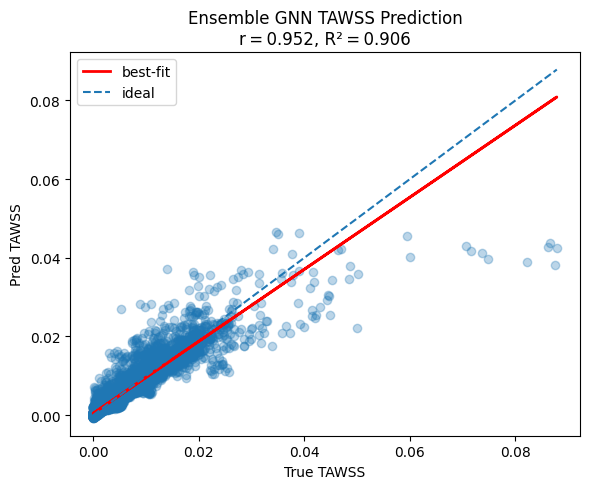

In [14]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── 1.  Ensemble predictions ────────────────────────────────────────────
all_preds, all_trues = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        # gather each model’s output
        outs = [m(batch) for m in ensemble_models]          # list[Tensor, …]
        mean_out = torch.stack(outs, dim=0).mean(dim=0)     # [batch_size, n_targets]

        all_preds.append(mean_out.cpu())
        all_trues.append(batch.y.cpu())

preds = torch.cat(all_preds, dim=0)
trues = torch.cat(all_trues, dim=0)

# ── 2.  Un‑normalize ────────────────────────────────────────────────────
preds = preds * y_std + y_mean
trues = trues * y_std + y_mean

preds = preds.numpy()
trues = trues.numpy()

labels = ["TAWSS"]

for i, lbl in enumerate(labels):
    y_true = trues[:, i]
    y_pred = preds[:, i]

    # ---- least‑squares line ----
    slope, intercept = np.polyfit(y_true, y_pred, deg=1)
    line = slope * y_true + intercept

    # ---- metrics ----
    r,  _ = pearsonr(y_true, y_pred)
    r2     = r2_score(y_true, y_pred)

    print(f"\n{lbl}")
    print(f"  slope      = {slope:.3f}")
    print(f"  intercept  = {intercept:.3f}")
    print(f"  Pearson r  = {r:.3f}")
    print(f"  R²         = {r2:.3f}")

    # ---- plot ----
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot(y_true, line, color="red", linewidth=2, label="best‑fit")   # ← red line
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn, mx], [mn, mx], linestyle="--", label="ideal")          # y = x
    plt.xlabel(f"True {lbl}")
    plt.ylabel(f"Pred {lbl}")
    plt.title(f"Ensemble GNN {lbl} Prediction\n"
              f"r = {r:.3f}, R² = {r2:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [15]:
# !zip -r fold_best_states.zip fold_best_states

In [175]:
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score

# ------------------------------------------------------------
# 0.  flat arrays of raw predictions and true values
# ------------------------------------------------------------
preds  = preds.flatten()     # (N,)
trues  = trues.flatten()     # (N,)

# ------------------------------------------------------------
# 1.  Monte-Carlo over random seeds
# ------------------------------------------------------------
n_runs   = 30
r2_raws  = []
r2_cals  = []

rng   = np.random.default_rng(0)                     # master RNG
seeds = rng.integers(1_000_000, size=n_runs)         # 30 different seeds

for seed in seeds:
    # ---- stratified 70/30 split on TRUE values ----
    bins = pd.qcut(trues, q=3, labels=False, duplicates='drop')
    sss  = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)
    (train_idx, test_idx), = sss.split(np.zeros_like(trues), bins)

    x_tr, y_tr = preds[train_idx], trues[train_idx]
    x_te, y_te = preds[test_idx],  trues[test_idx]

    # ---- Stage-1: linear fit on train ----
    lin = LinearRegression().fit(x_tr.reshape(-1, 1), y_tr)
    y_hat_tr = lin.predict(x_tr.reshape(-1, 1))

    # ---- Stage-2: isotonic residual fit δ(p) ----
    residuals = y_tr - y_hat_tr
    iso = IsotonicRegression(out_of_bounds="clip").fit(x_tr, residuals)

    # helper
    def calibrate(p):
        base = lin.predict(np.asarray(p).reshape(-1, 1)).ravel()
        corr = iso.predict(np.asarray(p)).ravel()
        return base + corr

    # ---- evaluate on hold-out ----
    y_raw = x_te                         # un-calibrated
    y_cal = calibrate(x_te)              # calibrated

    r2_raws.append(r2_score(y_te, y_raw))
    r2_cals.append(r2_score(y_te, y_cal))

# ------------------------------------------------------------
# 2.  summary
# ------------------------------------------------------------
print(f"Raw  R² : mean = {np.mean(r2_raws):.3f} ± {np.std(r2_raws):.3f}")
print(f"Cal  R² : mean = {np.mean(r2_cals):.3f} ± {np.std(r2_cals):.3f}")
print(f"ΔR²     : mean = {np.mean(np.array(r2_cals) - np.array(r2_raws)):.3f}")


Raw  R² : mean = 0.915 ± 0.007
Cal  R² : mean = 0.920 ± 0.009
ΔR²     : mean = 0.005


R² (raw):        0.900
R² (calibrated): 0.912


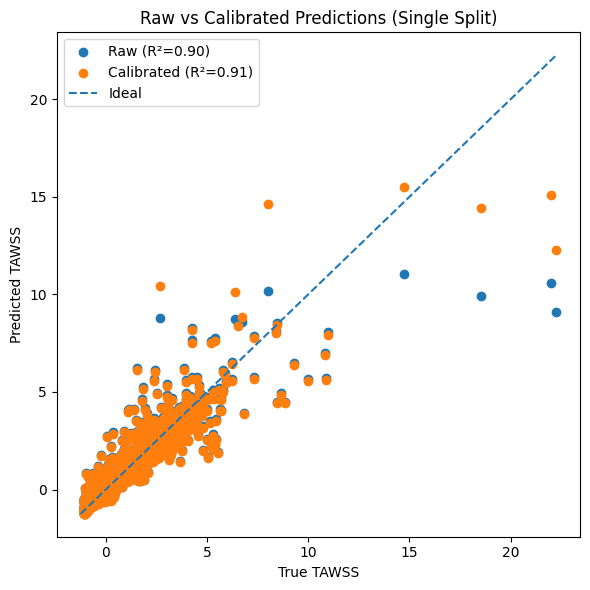

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score

def plot_single_calibration(preds, trues, seed=42):
    """
    Performs one stratified 70/30 split on (preds, trues), fits:
      - Raw predictions (identity)
      - Calibrated predictions (linear + isotonic residual)
    Computes R² for each, and plots both against the true values.
    """
    # Flatten inputs
    p = preds.flatten()
    t = trues.flatten()

    # Stratified bins on true values (6 quantiles)
    bins = pd.qcut(t, q=4, labels=False, duplicates='drop')

    # 70/30 stratified split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)
    train_idx, test_idx = next(sss.split(np.zeros_like(t), bins))
    x_tr, y_tr = p[train_idx], t[train_idx]
    x_te, y_te = p[test_idx],  t[test_idx]

    # Stage 1: linear fit on train
    lin = LinearRegression().fit(x_tr.reshape(-1,1), y_tr)

    # Stage 2: isotonic fit on residuals
    residuals = y_tr - lin.predict(x_tr.reshape(-1,1))
    iso = IsotonicRegression(out_of_bounds="clip").fit(x_tr, residuals)

    # Calibration function
    def calibrate(x):
        base = lin.predict(np.asarray(x).reshape(-1,1)).ravel()
        corr = iso.predict(np.asarray(x)).ravel()
        return base + corr

    # Predictions on hold-out
    y_raw = x_te
    y_cal = calibrate(x_te)

    # Compute R²
    r2_raw = r2_score(y_te, y_raw)
    r2_cal = r2_score(y_te, y_cal)

    # Print R²
    print(f"R² (raw):        {r2_raw:.3f}")
    print(f"R² (calibrated): {r2_cal:.3f}")

    # Plot
    plt.figure(figsize=(6,6))
    plt.scatter(y_te, y_raw, label=f"Raw (R²={r2_raw:.2f})")
    plt.scatter(y_te, y_cal, label=f"Calibrated (R²={r2_cal:.2f})")
    mn, mx = min(y_te.min(), y_raw.min(), y_cal.min()), max(y_te.max(), y_raw.max(), y_cal.max())
    plt.plot([mn, mx], [mn, mx], linestyle='--', label="Ideal")
    plt.xlabel("True TAWSS")
    plt.ylabel("Predicted TAWSS")
    plt.title("Raw vs Calibrated Predictions (Single Split)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Usage ---
plot_single_calibration(preds, trues, seed=42)


Pearson correlation r between STD and |residual|: 0.550 (p=0.00e+00)
SLR: |residual| = 0.0154 + 1.9326 * STD   (R² = 0.303)


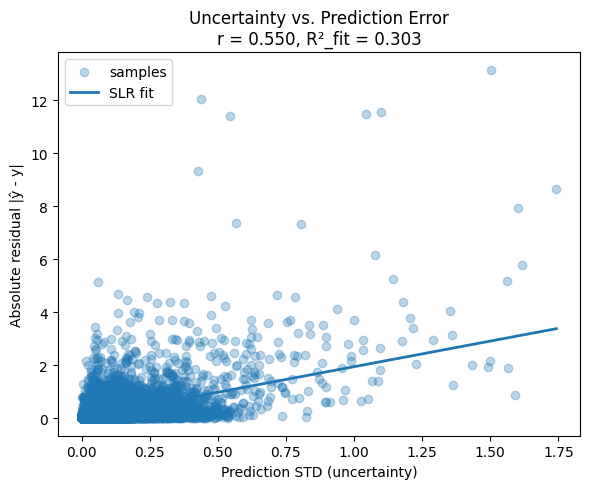

In [178]:
# Uncertainty Quantification Analysis (per "Uncertainty Quantification
# Approach for Regression Models" document)

import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 1) Gather per‑model predictions for all test samples
n_models = len(ensemble_models)
preds_per_model = [ [] for _ in range(n_models) ]   # list of length n_models
targets          = []                               # ground‑truth values

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        # save ground truth (assuming scalar regression target in batch.y)
        targets.append(batch.y.squeeze().cpu().numpy())
        # save each model's output
        for i, m in enumerate(ensemble_models):
            out = m(batch).squeeze().cpu().numpy()
            preds_per_model[i].append(out)

# concatenate lists → arrays of shape [N]
y_true = np.concatenate(targets)
per_model = [ np.concatenate(pm) for pm in preds_per_model ]   # list of arrays, each [N]

# 2) Compute ensemble mean prediction and sample‑wise uncertainty (STD)
pred_stack = np.stack(per_model, axis=1)         # shape [N, n_models]
y_pred     = pred_stack.mean(axis=1)             # mean across models
std_pred   = pred_stack.std(axis=1, ddof=1)      # unbiased STD across models

# 3) Absolute residuals (error magnitude)
abs_resid = np.abs(y_pred - y_true)

# 4) Correlation analysis
r, p = pearsonr(std_pred, abs_resid)
print(f"Pearson correlation r between STD and |residual|: {r:.3f} (p={p:.2e})")

# 5) Simple linear regression |residual| = α + β·STD
reg = LinearRegression().fit(std_pred.reshape(-1,1), abs_resid)
alpha, beta = reg.intercept_, reg.coef_[0]
r2 = reg.score(std_pred.reshape(-1,1), abs_resid)
print(f"SLR: |residual| = {alpha:.4f} + {beta:.4f} * STD   (R² = {r2:.3f})")

# 6) Visualisation
plt.figure(figsize=(6,5))
plt.scatter(std_pred, abs_resid, alpha=0.3, label='samples')
x_line = np.linspace(std_pred.min(), std_pred.max(), 200)
plt.plot(x_line, alpha + beta * x_line, linewidth=2, label='SLR fit')
plt.xlabel('Prediction STD (uncertainty)')
plt.ylabel('Absolute residual |ŷ - y|')
plt.title('Uncertainty vs. Prediction Error\n'
          f'r = {r:.3f}, R²_fit = {r2:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score

# --- parameters ---
n_outer = 25                       # how many different 80/20 splits
n_inner = 7                       # how many different λ‐tuning folds per outer split
lam_grid = np.linspace(0.0, 2.0, num=120)
eps      = 1e-8

# pre‐flattened arrays
# preds, trues, stds are all shape (N,)
bins = pd.qcut(trues, q=4, labels=False, duplicates='drop')

outer_seeds = np.random.default_rng(0).integers(0, 1_000_000, size=n_outer)
inner_seeds = np.random.default_rng(1).integers(0, 1_000_000, size=n_inner)

results = []  # to collect (outer_seed, mean_best_lam, r2_raw, r2_cal)

for seed0 in outer_seeds:
    # 0) Outer 80/20 split
    outer = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed0)
    (train80_idx, test20_idx), = outer.split(np.zeros_like(trues), bins)

    p_tr80, t_tr80, s_tr80 = preds[train80_idx], trues[train80_idx], stds[train80_idx]
    p_te20, t_te20, s_te20 = preds[test20_idx], trues[test20_idx], stds[test20_idx]

    best_lams = []
    # 1) Tune λ over several inner splits
    for seed1 in inner_seeds:
        inner = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed1)
        (in_idx, val_idx), = inner.split(np.zeros_like(t_tr80), bins[train80_idx])

        x_in,  y_in,  s_in  = p_tr80[in_idx],  t_tr80[in_idx],  s_tr80[in_idx]
        x_val, y_val, s_val = p_tr80[val_idx], t_tr80[val_idx], s_tr80[val_idx]

        # fit base models on inner‐train
        lin = LinearRegression().fit(x_in.reshape(-1,1), y_in)
        resid = y_in - lin.predict(x_in.reshape(-1,1))
        iso = IsotonicRegression(out_of_bounds="clip").fit(
            x_in, resid, sample_weight=1.0/(s_in + eps)
        )

        # evaluate each λ on inner‐val
        def make_calibrator(lam):
            def f(x, σ):
                base   = lin.predict(x.reshape(-1,1)).ravel()
                corr   = iso.predict(x).ravel()
                shrink = 1.0 / (1.0 + lam * σ)
                return base + shrink * corr
            return f

        # pick the best λ for this inner split
        lam_scores = {
            lam: r2_score(y_val, make_calibrator(lam)(x_val, s_val))
            for lam in lam_grid
        }
        best_lam = max(lam_scores, key=lam_scores.get)
        best_lams.append(best_lam)

    # average best λ over inner folds
    avg_lam = float(np.mean(best_lams))

    # 2) Refit on full 80% with avg_lam
    lin = LinearRegression().fit(p_tr80.reshape(-1,1), t_tr80)
    resid80 = t_tr80 - lin.predict(p_tr80.reshape(-1,1))
    iso80 = IsotonicRegression(out_of_bounds="clip").fit(
        p_tr80, resid80, sample_weight=1.0/(s_tr80 + eps)
    )
    calibrator = make_calibrator(avg_lam)

    # 3) Evaluate on held‐out 20%
    r2_raw = r2_score(t_te20, p_te20)
    r2_cal = r2_score(t_te20, calibrator(p_te20, s_te20))

    results.append((seed0, avg_lam, r2_raw, r2_cal))

# summarize
for seed0, lam0, r_raw, r_cal in results:
    print(f"outer_seed={seed0:>7} | λ*≈{lam0:.3f} | R² raw={r_raw:.3f} → cal={r_cal:.3f}")

# print average lam0
print(f"\nAverage λ*: {np.mean([lam0 for _, lam0, _, _ in results]):.3f}")


In [239]:
# ------------------------------------------------------------
# 0.  Ensemble forward pass  →  preds, stds, trues  (all N samples)
# ------------------------------------------------------------
import numpy as np, torch
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_models        = len(ensemble_models)
per_model_preds = [ [] for _ in range(n_models) ]
all_targets     = []

with torch.no_grad():
    for batch in test_loader:                     # use *full* dataset loader
        batch = batch.to(device)
        all_targets.append(batch.y.squeeze().cpu().numpy())
        for i, m in enumerate(ensemble_models):
            per_model_preds[i].append(m(batch).squeeze().cpu().numpy())

# flatten lists → (N,) arrays
y_true = np.concatenate(all_targets)
per_model = [np.concatenate(pm) for pm in per_model_preds]   # list length n_models

pred_stack = np.stack(per_model, axis=1)   # [N, n_models]
preds = pred_stack.mean(axis=1)            # ensemble mean
stds  = pred_stack.std(axis=1, ddof=1)     # ensemble spread (uncertainty)

trues = y_true                             # keep naming in sync with old code

# ------------------------------------------------------------
# 1.  Monte-Carlo stratified calibration with UQ weighting
# ------------------------------------------------------------
n_runs = 500
lam    = 0.9          # shrinkage strength; tune on a val split
eps    = 1e-8

rng   = np.random.default_rng(0)
seeds = rng.integers(1_000_000, size=n_runs)

r2_raws, r2_cals = [], []

best_seed = 0
best_diff = 0

for seed in seeds:
    # ---- stratified 70/30 split on TRUE values ----
    bins = pd.qcut(trues, q=4, labels=False, duplicates='drop')
    sss  = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)
    (train_idx, test_idx), = sss.split(np.zeros_like(trues), bins)

    x_tr, y_tr, s_tr = preds[train_idx], trues[train_idx], stds[train_idx]
    x_te, y_te, s_te = preds[test_idx],  trues[test_idx],  stds[test_idx]

    # ---- Stage-1 linear fit ----
    lin = LinearRegression().fit(x_tr.reshape(-1, 1), y_tr)
    y_hat_tr = lin.predict(x_tr.reshape(-1, 1))

    # ---- Stage-2 isotonic residual fit with inverse-σ weights ----
    residuals = y_tr - y_hat_tr
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(x_tr, residuals, sample_weight=1.0/(s_tr + eps))

    # helper: uncertainty-shrunk correction
    def calibrate_exp(x, σ, lam=2.0):
      base = lin.predict(x.reshape(-1,1)).ravel()
      corr = iso.predict(x).ravel()
      shrink = np.exp(-lam * σ)
      return base + shrink * corr



    # ---- evaluate on hold-out ----
    y_raw = x_te                # un-calibrated
    y_cal = calibrate(x_te, s_te)

    r2_raw = r2_score(y_te, y_raw)
    r2_cal = r2_score(y_te, y_cal)
    r2_raws.append(r2_raw)
    r2_cals.append(r2_cal)
    if r2_cal - r2_raw > best_diff:
        best_diff = r2_cal - r2_raw
        best_seed = seed

# ------------------------------------------------------------
# 2.  summary
# ------------------------------------------------------------
print(f"Raw  R² : mean = {np.mean(r2_raws):.3f} ± {np.std(r2_raws):.3f}")
print(f"Cal  R² : mean = {np.mean(r2_cals):.3f} ± {np.std(r2_cals):.3f}")
print(f"ΔR²     : mean = {np.mean(np.array(r2_cals) - np.array(r2_raws)):.3f}")
print(f"Best seed: {best_seed} (ΔR² = {best_diff:.3f})")

Raw  R² : mean = 0.906 ± 0.009
Cal  R² : mean = 0.914 ± 0.007
ΔR²     : mean = 0.008
Best seed: 778468 (ΔR² = 0.016)


R² (raw)       : 0.900
R² (calibrated): 0.911


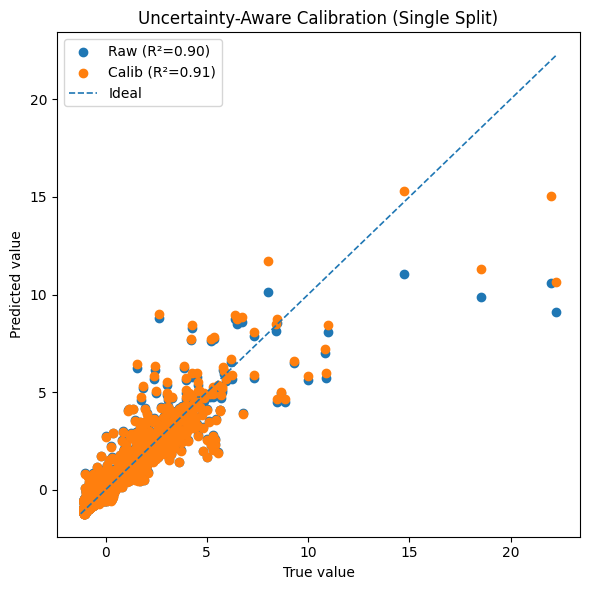

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score

def plot_single_calibration_uq(preds, trues, stds, *, lam=0.9, eps=1e-8, seed=42):
    """
    One stratified 70/30 split with uncertainty-aware calibration.

    Args
    ----
    preds : (N,) ndarray
        Ensemble mean predictions.
    trues : (N,) ndarray
        Ground-truth targets.
    stds  : (N,) ndarray
        Per-sample ensemble standard deviation (uncertainty).
    lam   : float, default 1.0
        Shrinkage strength: larger → trust corrections less when σ is large.
    eps   : float, default 1e-8
        Numerical safeguard in inverse-σ weights.
    seed  : int,   default 42
        Random seed for the stratified split.
    """
    # Flatten inputs
    p = preds.flatten()
    t = trues.flatten()
    s = stds.flatten()

    # 1) Stratified bins on true values (quartiles)
    bins = pd.qcut(t, q=4, labels=False, duplicates='drop')

    # 70/30 stratified split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=seed)
    train_idx, test_idx = next(sss.split(np.zeros_like(t), bins))
    x_tr, y_tr, s_tr = p[train_idx], t[train_idx], s[train_idx]
    x_te, y_te, s_te = p[test_idx],  t[test_idx],  s[test_idx]

    # 2) Stage-1 linear fit
    lin = LinearRegression().fit(x_tr.reshape(-1, 1), y_tr)

    # 3) Stage-2 isotonic fit on residuals, weighted by inverse σ
    resid = y_tr - lin.predict(x_tr.reshape(-1, 1))
    iso   = IsotonicRegression(out_of_bounds="clip")
    iso.fit(x_tr, resid, sample_weight=1.0 / (s_tr + eps))

    # 4) Calibration function with shrinkage when σ is large
    def calibrate(x, σ):
        base   = lin.predict(np.asarray(x).reshape(-1, 1)).ravel()
        corr   = iso.predict(np.asarray(x)).ravel()
        shrink = 1.0 / (1.0 + lam * σ)          # less correction if σ is large
        return base + shrink * corr

    # 5) Predictions on hold-out
    y_raw = x_te
    y_cal = calibrate(x_te, s_te)

    # 6) R² scores
    r2_raw = r2_score(y_te, y_raw)
    r2_cal = r2_score(y_te, y_cal)

    print(f"R² (raw)       : {r2_raw:.3f}")
    print(f"R² (calibrated): {r2_cal:.3f}")

    # 7) Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_te, y_raw,  alpha=1.0, label=f"Raw (R²={r2_raw:.2f})")
    plt.scatter(y_te, y_cal,  alpha=1.0, label=f"Calib (R²={r2_cal:.2f})")
    mn = min(y_te.min(), y_raw.min(), y_cal.min())
    mx = max(y_te.max(), y_raw.max(), y_cal.max())
    plt.plot([mn, mx], [mn, mx], ls='--', lw=1.2, label="Ideal")
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.title("Uncertainty-Aware Calibration (Single Split)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_single_calibration_uq(preds, trues, stds, lam=0.9, seed=42)